# What drives the price of a car?

![](images/kurt.jpeg)

### Business Understanding

Using a dataset with over 400,000 used car sale prices, we will try to uncover the most important attributes that drive the sale of used car. We will apply several models and search for the best hyperparameters for the models which produce the most accurate results. To validate our models we will keep a set of holdout data that is not provided to the model training phase.

### Data Understanding

In order to get more familiar with our data we will need to look at a few key aspects:

1. Which fields are available for consideration.
2. Which fields are missing information, and can we provide a default value for the missing data.
3. Which information can be ignored and dropped from our analysis.

In [68]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore")

In [3]:
vehicles = pd.read_csv('data/vehicles.csv')
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
# We can look at the various categorical columns individually to see what data they
# contain and the numbers of vehicles of each category. For instance the cylinders 
# column may be a good proxy for horsepower, and it might be convertible to a numeric
# value. However there are a lot of missing values and the 'other' value would throw
# off any regression that tries to predict price from cylinders if we encode 'other' as
# either zero or a large number. This will have to be one-hot and filled with 'other'.
vehicles[['cylinders']].value_counts()

cylinders   
6 cylinders     94169
4 cylinders     77642
8 cylinders     72062
5 cylinders      1712
10 cylinders     1455
other            1298
3 cylinders       655
12 cylinders      209
Name: count, dtype: int64

In [5]:
# Condition could be turned into a set of one-hot encoded columns with 'unknown'
# filled in for cars that are missing the data. It would be better to turn this 
# into an ordinal value as it clearly increases in qualityfrom salvage to new.
vehicles[['condition']].value_counts()

condition
good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: count, dtype: int64

In [6]:
vehicles[['title_status']].value_counts()

title_status
clean           405117
rebuilt           7219
salvage           3868
lien              1422
missing            814
parts only         198
Name: count, dtype: int64

In [7]:
# The model data is very dirty with values that include flame emoji. It also has a
# very high cardinality of 28,567 unique values. This isn't extremely useful for us.
vehicles[['model']].value_counts()

model                      
f-150                          8009
silverado 1500                 5140
1500                           4211
camry                          3135
silverado                      3023
                               ... 
crosstrek 2.0i premium aw         1
crosstrek 2.0i prem               1
crosstrek 2.0i limited cvt        1
crosstrek 2.0i limited aw         1
🔥GMC Sierra 1500 SLE🔥 4X4 🔥       1
Name: count, Length: 29649, dtype: int64

In [114]:
# Lots of values for 'other' in fuel type.
vehicles[['fuel']].value_counts()

fuel    
gas         211249
other        21526
diesel       13420
hybrid        3479
electric      1161
Name: count, dtype: int64

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [8]:
# From the info method, we can see that there are many missing values for key 
# attributes of model year, fuel, condition, and odometer. We can drop rows missing
# values in any key column so that we have data on each car for those values.
vehicles.dropna(subset = ['odometer', 'year', 'fuel', 'condition'], inplace=True)
print(f"Number of vehicles with key statistics: {vehicles.shape[0]}")

Number of vehicles with key statistics: 250835


In [9]:
# We can drop several columns with high cardinality or low quality.
vehicles.drop(['VIN', 'model', 'size', 'region'],axis = 1, inplace=True)

In [10]:
# Fill in the missing values for cylinders, manufacturer, etc.
# Some of these already had an "other" value so we use that instead of unknown.
vehicles['manufacturer'] = vehicles['manufacturer'].fillna('unknown')
vehicles['cylinders'] = vehicles['cylinders'].fillna('other')
vehicles['title_status'] = vehicles['title_status'].fillna('unknown')
vehicles['transmission'] = vehicles['transmission'].fillna('other')
vehicles['drive'] = vehicles['drive'].fillna('unknown')
vehicles['type'] = vehicles['type'].fillna('other')
vehicles['paint_color'] = vehicles['paint_color'].fillna('unknown')

In [11]:
# Drop prices more than 1.5 IQR and less than 100 as outliers
first_quartile = vehicles['price'].quantile(0.25)
third_quartile = vehicles['price'].quantile(0.75)
iqr = third_quartile - first_quartile
lower = max(first_quartile - 1.5 * iqr, 99)
upper = third_quartile + 1.5 * iqr
print(f"Lower {lower} upper {upper}")
vehicles_cleaned = vehicles[(vehicles['price'] > lower) & (vehicles['price'] < upper)]
print(f"Dropped {vehicles.shape[0] - vehicles_cleaned.shape[0]}")

Lower 99 upper 57650.0
Dropped 14024


[Text(0.5, 0, 'Price $'), Text(0.5, 1.0, 'Histogram of vehicle price')]

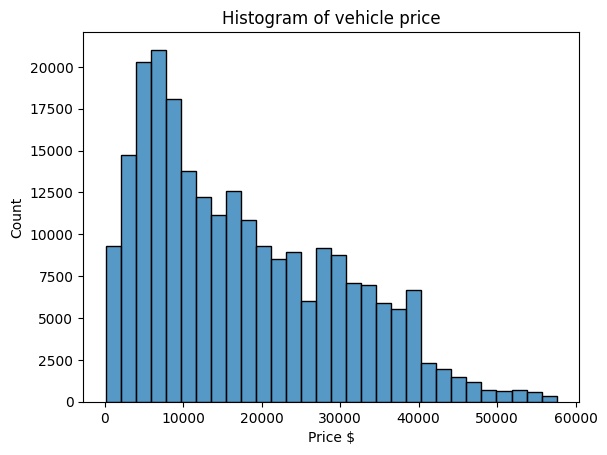

In [35]:
sns.histplot(vehicles_cleaned['price'], bins=30).set(xlabel='Price $', title='Histogram of vehicle price')

In [19]:
# Create one-hot and ordinal encoders
print(f"Shape before transform {vehicles_cleaned.shape}")
ordinal_ohe_transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['manufacturer', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state']),
                                          (OrdinalEncoder(categories=[['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]), ['condition']),
                                          remainder='passthrough', verbose_feature_names_out=False, sparse_threshold = 0)
vehicles_transformed=ordinal_ohe_transformer.fit_transform(vehicles_cleaned)
feature_names = ordinal_ohe_transformer.get_feature_names_out()
vehicles_df = pd.DataFrame(vehicles_transformed, columns=feature_names).set_index('id')
print(f"Shape after transform {vehicles_df.shape}")

Shape before transform (236811, 14)
Shape after transform (236811, 151)


### Modeling

We'll try our dataset with several models attempting to find the one that offers the best predictions versus the actual values of our cross validation holdout data.

In [71]:
# Split the data into X(all the features) and y(the target), then create training and test sets of data.
X = vehicles_df.drop('price', axis=1)
y = vehicles_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [72]:
# Lets take a look at linear regression.
linreg = LinearRegression()
linreg.fit(X_train, y_train)

predictions = linreg.predict(X_test)
linreg_mse = mean_squared_error(y_test, predictions)
print(f"Linear regression MSE: {linreg_mse} sqrt(MSE) = {np.sqrt(linreg_mse)}")

Linear regression MSE: 71625582.65112863 sqrt(MSE) = 8463.189862642137


In [73]:
# A mean price error over $8000 isn't very good. Lets try using a Ridge regression with Grid search over alpha values.
ridge = Pipeline([
    ('standardize', StandardScaler()),
    ('ridge', Ridge())
])
params_dict = {'ridge__alpha': np.logspace(0, 10, 20)}
grid = GridSearchCV(estimator=ridge, param_grid=params_dict)
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardize', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e+00, 3.35981829e+00, 1.12883789e+01, 3.79269019e+01,
       1.27427499e+02, 4.28133240e+02, 1.43844989e+03, 4.83293024e+03,
       1.62377674e+04, 5.45559478e+04, 1.83298071e+05, 6.15848211e+05,
       2.06913808e+06, 6.95192796e+06, 2.33572147e+07, 7.84759970e+07,
       2.63665090e+08, 8.85866790e+08, 2.97635144e+09, 1.00000000e+10])})

In [74]:
best_estimator = grid.best_estimator_
predictions = best_estimator.predict(X_test)
ridge_mse = mean_squared_error(y_test, predictions)
print(f"Ridge regression MSE: {ridge_mse} sqrt(MSE) = {np.sqrt(ridge_mse)}")

Ridge regression MSE: 71623972.97351743 sqrt(MSE) = 8463.094763354446


In [76]:
# That's identical to simple LinearRegression. Lets see what hyperparameters it chose.
grid.best_params_

{'ridge__alpha': 428.1332398719391}

In [60]:
# On the first pass we didn't get very good results. Without more memory, it is not possible to try PolynomialFeatures with a degree of 2.
# However, it is likely that some features may not be linearly related to the price. We can reduce the number of features by removing the one-hot encodings
# for several columns.
vehicles_fewer_features = vehicles_cleaned.drop(['manufacturer', 'paint_color', 'state'], axis=1)
ordinal_ohe_transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type']),
                                          (OrdinalEncoder(categories=[['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]), ['condition']),
                                          remainder='passthrough', verbose_feature_names_out=False, sparse_threshold = 0)
vehicles_transformed=ordinal_ohe_transformer.fit_transform(vehicles_fewer_features)
feature_names = ordinal_ohe_transformer.get_feature_names_out()
vehicles_df_fewer_features = pd.DataFrame(vehicles_transformed, columns=feature_names).set_index('id')

In [77]:
X = vehicles_df_fewer_features.drop('price', axis=1)
y = vehicles_df_fewer_features['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [78]:
linreg_quad = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('linreg', LinearRegression())
])
linreg_quad.fit(X_train, y_train)
predictions = linreg_quad.predict(X_test)
linreg_quad_mse = mean_squared_error(predictions, y_test)
print(f"Linear regression with quadratic features MSE: {linreg_quad_mse} sqrt(MSE) = {np.sqrt(linreg_quad_mse)}")

Linear regression with quadratic features MSE: 50267395.5328969 sqrt(MSE) = 7089.95031949427


In [79]:
ridge = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('standardize', StandardScaler()),
    ('ridge', Ridge())
])
params_dict = {'ridge__alpha': np.logspace(0, 10, 20)}
grid = GridSearchCV(estimator=ridge, param_grid=params_dict)
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('standardize', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e+00, 3.35981829e+00, 1.12883789e+01, 3.79269019e+01,
       1.27427499e+02, 4.28133240e+02, 1.43844989e+03, 4.83293024e+03,
       1.62377674e+04, 5.45559478e+04, 1.83298071e+05, 6.15848211e+05,
       2.06913808e+06, 6.95192796e+06, 2.33572147e+07, 7.84759970e+07,
       2.63665090e+08, 8.85866790e+08, 2.97635144e+09, 1.00000000e+10])})

In [80]:
best_estimator = grid.best_estimator_
predictions = best_estimator.predict(X_test)
ridge_mse = mean_squared_error(y_test, predictions)
print(f"Ridge regression MSE: {ridge_mse} sqrt(MSE) = {np.sqrt(ridge_mse)}")

Ridge regression MSE: 46472947.24195171 sqrt(MSE) = 6817.106955443175


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [81]:
# Looking for the most important features by testing permutations on the accuracy of predictions.
# We highlight any whose importance is within two standard deviations of the mean.
r = permutation_importance(best_estimator, X_test, y_test, random_state=42)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8}"
              f" {r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

fuel_gas 7.422 +/- 0.049
fuel_other 4.783 +/- 0.040
transmission_automatic 4.452 +/- 0.041
title_status_clean 4.318 +/- 0.020
cylinders_6 cylinders 3.681 +/- 0.034
cylinders_other 3.629 +/- 0.034
cylinders_8 cylinders 3.618 +/- 0.030
transmission_other 3.617 +/- 0.027
type_sedan 3.515 +/- 0.052
cylinders_4 cylinders 3.220 +/- 0.042
drive_4wd 2.991 +/- 0.023
drive_unknown 2.762 +/- 0.028
type_other 2.737 +/- 0.013
drive_fwd 2.632 +/- 0.048
type_SUV 2.465 +/- 0.020
drive_rwd 2.185 +/- 0.030
type_pickup 2.093 +/- 0.023
fuel_diesel 2.069 +/- 0.027
title_status_rebuilt 1.650 +/- 0.017
transmission_manual 1.534 +/- 0.024
type_truck 1.453 +/- 0.025
type_coupe 1.246 +/- 0.011
type_hatchback 1.100 +/- 0.026
title_status_salvage 0.846 +/- 0.009
title_status_unknown 0.743 +/- 0.004
type_convertible 0.582 +/- 0.005
fuel_hybrid 0.545 +/- 0.008
type_wagon 0.448 +/- 0.014
year     0.438 +/- 0.003
title_status_lien 0.416 +/- 0.008
type_van 0.367 +/- 0.006
type_mini-van 0.246 +/- 0.005
title_status_mis

In [82]:
best_ridge_alpha = grid.best_params_['ridge__alpha']
print(f"Best ridge alpha value: {best_ridge_alpha}")

Best ridge alpha value: 1.0


#### Evaluation summary.
Being within $7,000 isn't the best prediction of actual vehicle price. However, it is at good enough to determine which factors contribute the most to increasing used vehicle prices.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

#### Best effort estimation

When evaluating all of the data, our best estimator was +/- $6800 on estimating the price of a vehicle. The values that contributed the most to the price were the following:
* Not running on gasoline
* Without an automatic transmission
* Having a clean title
* An engine with 6 or 8 cylinders
* Having four wheel drive

Further down the list, but still significant:
* The year of the vehicle
* Odometer reading


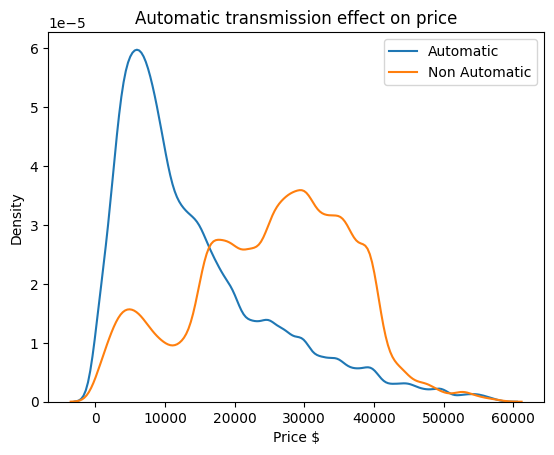

In [105]:
sns.kdeplot(vehicles_df_fewer_features.query('transmission_automatic == 1')['price'], label='Automatic').set(xlabel='Price $', title='Automatic transmission effect on price')
sns.kdeplot(vehicles_df_fewer_features.query('transmission_automatic == 0')['price'], label='Non Automatic')
plt.legend()

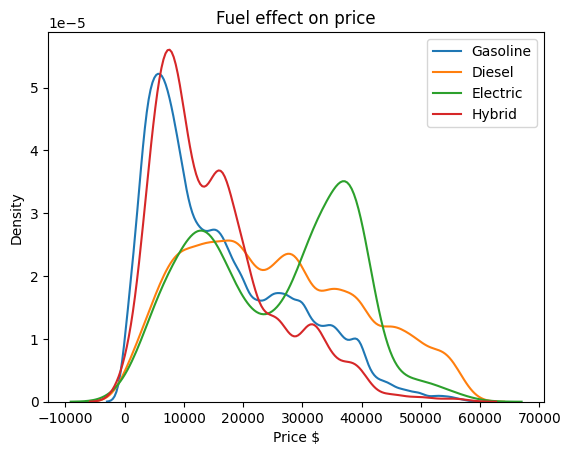

In [115]:
sns.kdeplot(vehicles_df_fewer_features.query('fuel_gas == 1')['price'], label='Gasoline').set(xlabel='Price $', title='Fuel effect on price')
sns.kdeplot(vehicles_df_fewer_features.query('fuel_diesel == 1')['price'], label='Diesel')
sns.kdeplot(vehicles_df_fewer_features.query('fuel_electric == 1')['price'], label='Electric')
sns.kdeplot(vehicles_df_fewer_features.query('fuel_hybrid == 1')['price'], label='Hybrid')
plt.legend()

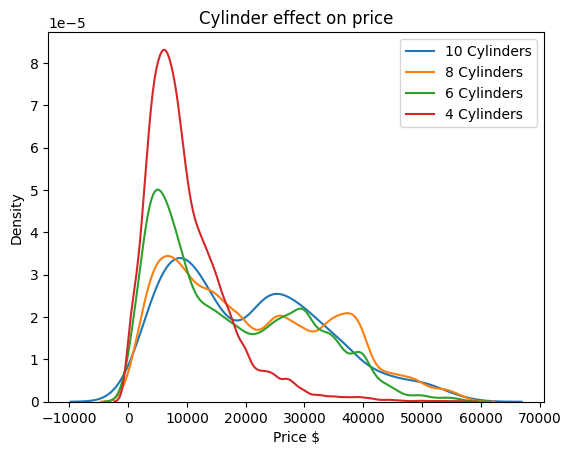

In [113]:
sns.kdeplot(vehicles_df_fewer_features.query('`cylinders_10 cylinders` == 1')['price'], label='10 Cylinders').set(xlabel='Price $', title='Cylinder effect on price')
sns.kdeplot(vehicles_df_fewer_features.query('`cylinders_8 cylinders` == 1')['price'], label='8 Cylinders')
sns.kdeplot(vehicles_df_fewer_features.query('`cylinders_6 cylinders` == 1')['price'], label='6 Cylinders')
sns.kdeplot(vehicles_df_fewer_features.query('`cylinders_4 cylinders` == 1')['price'], label='4 Cylinders')
plt.legend()

#### Conclusion
To increase the average price of vehicles on your lot, look for vehicles without automatic transmissions, that run on electricity, or have larger engines with a sweet spot at 8 cylinders.